<a href="https://colab.research.google.com/github/StatsAI/streamlit_image_search_db/blob/main/Image_Search_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install jupyter pandas sentence_transformers "qdrant_client~=1.3.0" pyarrow

!pip install DeepImageSearch --upgrade


In [6]:
import DeepImageSearch.config as config
from DeepImageSearch import Load_Data, Search_Setup
import requests
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torch
from torch.autograd import Variable
import timm
from PIL import ImageOps
import math
import faiss
import time

In [7]:
def download_and_unzip(url):
    response = requests.get(url)
    with open("archive.zip", "wb") as f:
        f.write(response.content)

    with zipfile.ZipFile("archive.zip", "r") as zip_ref:
        zip_ref.extractall()


def load_assets():
	# Load images from a folder
	image_list = Load_Data().from_folder(['animals'])

	# Load indexed images
	loaded_index = faiss.read_index("image_features_vectors.idx")

	# Load image features
	image_data = pd.read_pickle("image_data_features.pkl")

	return image_list, loaded_index, image_data

In [8]:
url = "https://github.com/StatsAI/streamlit_image_search/releases/download/image_search_assets/archive.zip"
download_and_unzip(url)

url = "https://github.com/StatsAI/streamlit_image_search/releases/download/image_search_assets/faiss_assets.zip"
download_and_unzip(url)

image_list, loaded_index, image_data = load_assets()

In [9]:
print("Total Image Count:",len(image_list))
print("Samples:")
print(image_list[:10])

Total Image Count: 5400
Samples:
['animals/animals/bison/8e34044b98.jpg', 'animals/animals/bison/73b10839bc.jpg', 'animals/animals/bison/35e68b0489.jpg', 'animals/animals/bison/3ac6b41fff.jpg', 'animals/animals/bison/74dc1dd32a.jpg', 'animals/animals/bison/87a5c700ad.jpg', 'animals/animals/bison/75ab166a7d.jpg', 'animals/animals/bison/3d657e1eb5.jpg', 'animals/animals/bison/17fd28dbd4.jpg', 'animals/animals/bison/2e29f399bd.jpg']


In [10]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image

model = SentenceTransformer("clip-ViT-B-32")

In [11]:
image_list[350]

'animals/animals/bee/2e3d7a7bd4.jpg'

In [12]:
img_emb = model.encode(Image.open(image_list[350]))

img_emb.shape

(512,)

In [13]:
#Encode text descriptions
text_emb = model.encode(['A grizzly bear', 'A polar bear', 'A black bear', 'London at night'])

text_emb.shape

(4, 512)

In [14]:
#Compute cosine similarities
cos_scores = util.cos_sim(img_emb, text_emb)
print(cos_scores)

tensor([[0.1805, 0.1382, 0.1408, 0.1120]])


In [15]:
from typing import List

def calculate_embedding(image_path: str):
    try:
        image = Image.open(image_path)
        return model.encode(image).tolist()
    except:
        return None

In [17]:
import time

start = time.time()

img_emb = list(map(calculate_embedding, image_list))

end = time.time()


# print the difference between start
# and end time in milli. secs
print("The code took this many minutes to execute: ",
      (end-start)/60)

The code took this many minutes to execute:  28.315489546457925


In [20]:
import pickle

with open("img_emb.pkl", "wb") as fOut:
  pickle.dump(img_emb, fOut)

In [55]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage
import os
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageOps

In [46]:
import pickle

# Load the embeddings from the pickle file.
with open("img_emb.pkl", "rb") as fIn:
  img_emb_loaded = pickle.load(fIn)

# Encode the text "bear".
bear_embedding = model.encode("bear")

# Convert the embeddings to tensors.
img_emb_loaded = torch.tensor(img_emb_loaded)
bear_embedding = torch.tensor(bear_embedding)

# Find the top 10 most similar images to the bear embedding.
most_similar_images = util.semantic_search(query_embeddings = bear_embedding, corpus_embeddings = img_emb_loaded, top_k = 10)

most_similar_images

input_img = Image.open(image_path)

input_img_resized = ImageOps.fit(input_img, (224, 224), Image.LANCZOS)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('Input Image', fontsize=18)
plt.imshow(input_img_resized)
plt.show()

[[{'corpus_id': 2706, 'score': 0.3042844235897064},
  {'corpus_id': 2734, 'score': 0.3017863929271698},
  {'corpus_id': 2702, 'score': 0.29929864406585693},
  {'corpus_id': 2714, 'score': 0.2982271611690521},
  {'corpus_id': 2744, 'score': 0.29740896821022034},
  {'corpus_id': 2719, 'score': 0.29710906744003296},
  {'corpus_id': 2742, 'score': 0.2970101237297058},
  {'corpus_id': 2720, 'score': 0.2957366406917572},
  {'corpus_id': 2752, 'score': 0.2954465448856354},
  {'corpus_id': 2721, 'score': 0.29477447271347046}]]

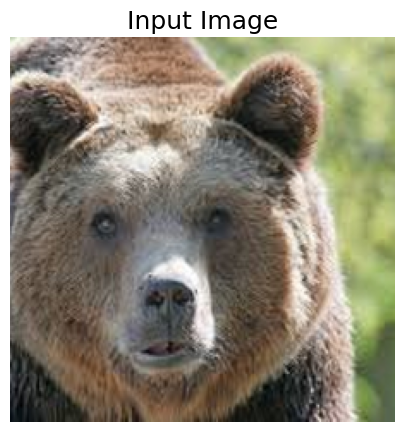

In [63]:
image_path = image_list[2721]

input_img = Image.open(image_path)

input_img_resized = ImageOps.fit(input_img, (224, 224), Image.LANCZOS)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('Input Image', fontsize=18)
plt.imshow(input_img_resized)
plt.show()

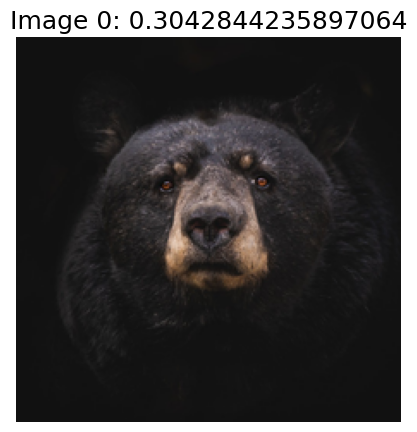

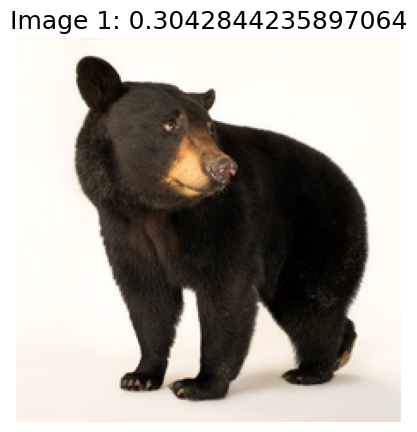

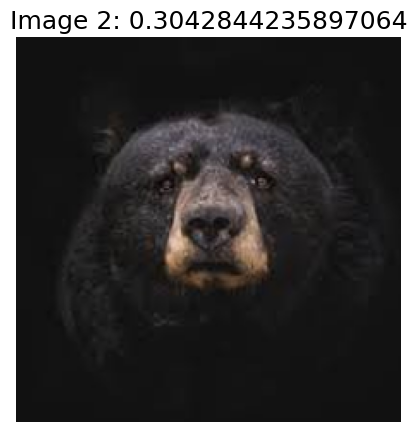

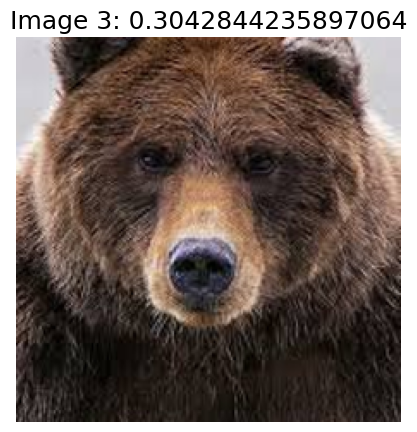

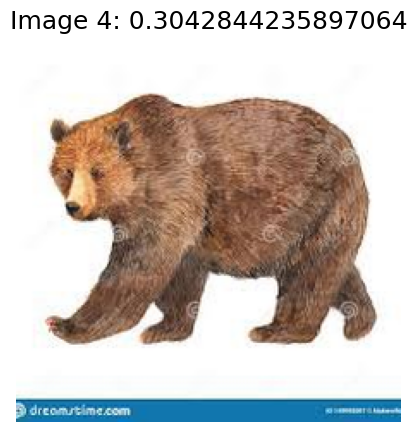

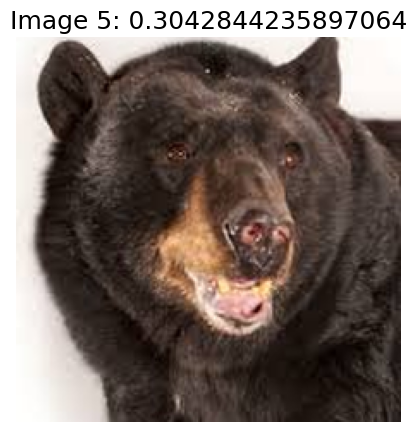

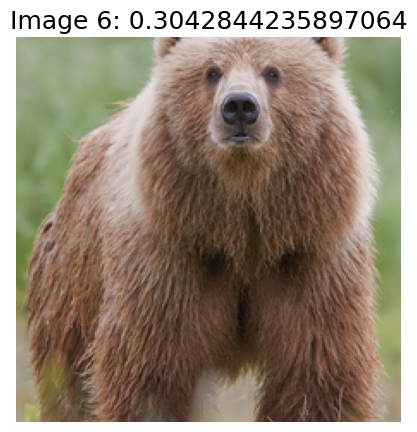

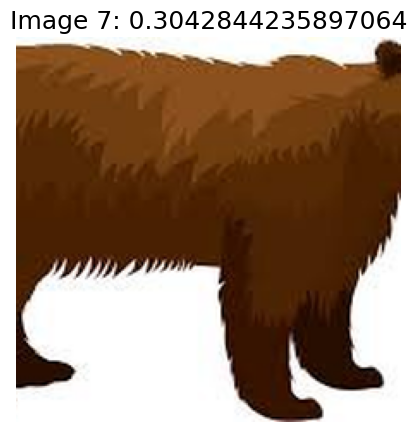

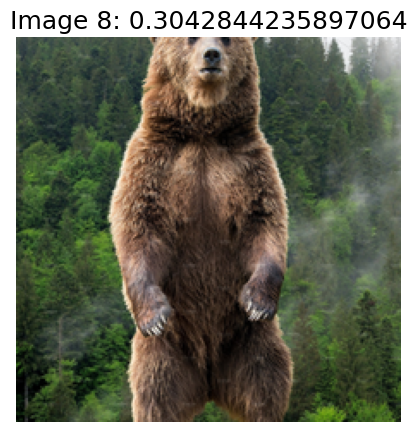

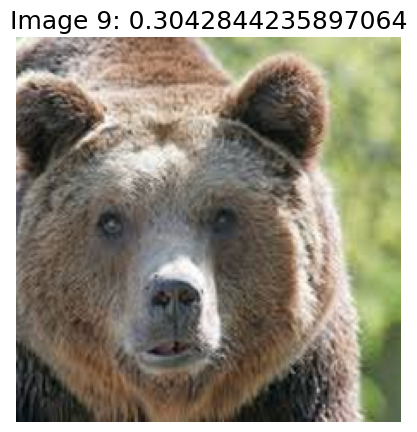

In [119]:
import pickle

# Load the embeddings from the pickle file.
with open("img_emb.pkl", "rb") as fIn:
  img_emb_loaded = pickle.load(fIn)

# Encode the text "bear".
bear_embedding = model.encode("bear")

# Convert the embeddings to tensors.
img_emb_loaded = torch.tensor(img_emb_loaded)
bear_embedding = torch.tensor(bear_embedding)

# Find the top 10 most similar images to the bear embedding.
most_similar_images = util.semantic_search(query_embeddings = bear_embedding, corpus_embeddings = img_emb_loaded, top_k = 10)

# Create a list to store the results.
results = []

# Loop over the images in the most_similar_images variable.
for i in range(len(most_similar_images[0])):
  # Get the image ID and score of the current image.
  image_id = most_similar_images[0][i]['corpus_id']
  image_score = most_similar_images[0][i]['score']

  # Add the image ID and score to the results list.
  results.append([image_id, image_score])

## Print the results.
#print(results)

for i in range(len(results)):
  image_number = results[i][0]
  image_name = image_list[image_number]

  image = Image.open(image_name)
  image_resized = ImageOps.fit(image, (224, 224), Image.LANCZOS)
  plt.figure(figsize=(5, 5))
  plt.axis('off')
  plt.title(f"Image {i}: {score}", fontsize=18)
  plt.imshow(image_resized)
  plt.show()

In [120]:
most_similars_images

[[{'corpus_id': 2706, 'score': 0.3042844235897064},
  {'corpus_id': 2734, 'score': 0.3017863929271698},
  {'corpus_id': 2702, 'score': 0.29929864406585693},
  {'corpus_id': 2714, 'score': 0.2982271611690521},
  {'corpus_id': 2744, 'score': 0.29740896821022034},
  {'corpus_id': 2719, 'score': 0.29710906744003296},
  {'corpus_id': 2742, 'score': 0.2970101237297058},
  {'corpus_id': 2720, 'score': 0.2957366406917572},
  {'corpus_id': 2752, 'score': 0.2954465448856354},
  {'corpus_id': 2721, 'score': 0.29477447271347046}]]

In [111]:
range(len(most_similar_images[0]))

range(0, 10)

In [112]:
# Create a list to store the results.
results = []

# Loop over the images in the most_similar_images variable.
for i in range(len(most_similar_images[0])):
  # Get the image ID and score of the current image.
  image_id = most_similar_images[0][i]['corpus_id']
  image_score = most_similar_images[0][i]['score']

  # Add the image ID and score to the results list.
  results.append([image_id, image_score])

# Print the results.
print(results)

[[2706, 0.3042844235897064], [2734, 0.3017863929271698], [2702, 0.29929864406585693], [2714, 0.2982271611690521], [2744, 0.29740896821022034], [2719, 0.29710906744003296], [2742, 0.2970101237297058], [2720, 0.2957366406917572], [2752, 0.2954465448856354], [2721, 0.29477447271347046]]


In [116]:
results[0][0]

2706

In [117]:
results[0][1]

0.3042844235897064

In [99]:
for i in most_similar_images:
  image_id = most_similar_images[0][i]['corpus_id']
  image_score = most_similar_images[0][i]['score']
  results = [image_id, score]

TypeError: ignored

In [102]:
most_similar_images[0][1]['corpus_id']

2734

In [96]:
most_similar_images[0][1]['corpus_id']

2734

In [97]:
most_similar_images[0][1]['score']

0.3017863929271698

In [94]:
# Turn the most_similar_images variable into a regular dictionary.
dict_most_similar_images = {}
for i, image_info in enumerate(most_similar_images):
  corpus_id = image_info[0]['corpus_id']
  score = image_info[0]['score']
  dict_most_similar_images[i] = {'corpus_id': corpus_id, 'score': score}

print(dict_most_similar_images)

{0: {'corpus_id': 2706, 'score': 0.3042844235897064}}


In [95]:
dict_most_similar_images

{0: {'corpus_id': 2706, 'score': 0.3042844235897064}}

In [21]:
import time

def keep_alive():
  """This function sends a request to the Colab server every 60 seconds, preventing the session from timing out."""
  while True:
    time.sleep(60)
    url = "https://colab.research.google.com/assets/colab-static/colab-index-favicon.svg"
    requests.get(url)

if __name__ == "__main__":
  keep_alive()

KeyboardInterrupt: ignored

In [ ]:
img_emb = list(map(calculate_embedding, image_list))

In [48]:
image_list[:2]

['animals/animals/bison/8e34044b98.jpg',
 'animals/animals/bison/73b10839bc.jpg']

In [47]:
calculate_embedding(image_list[0])

[0.22824302315711975,
 -0.0723060667514801,
 0.5929747223854065,
 0.5380374193191528,
 -0.43529507517814636,
 0.00756227970123291,
 0.21024979650974274,
 0.03273770958185196,
 -0.09656530618667603,
 0.36185404658317566,
 0.34775808453559875,
 -0.06344307214021683,
 0.3481299877166748,
 -0.284822016954422,
 0.1630919873714447,
 0.17268222570419312,
 -0.8129740953445435,
 0.08216610550880432,
 -0.08333627134561539,
 0.3537347912788391,
 -0.7258581519126892,
 0.44388172030448914,
 -0.21086683869361877,
 -0.8475488424301147,
 -0.34581315517425537,
 -0.046963274478912354,
 -0.16066734492778778,
 -0.8212361335754395,
 0.20567256212234497,
 -0.3419167697429657,
 0.541346549987793,
 -0.1944548785686493,
 -0.07316422462463379,
 -0.14106881618499756,
 0.21438133716583252,
 0.5674172043800354,
 -0.1414552628993988,
 0.21970514953136444,
 0.2542043626308441,
 1.9371814727783203,
 0.11053385585546494,
 -0.12167681008577347,
 -0.22620739042758942,
 -0.39588814973831177,
 0.24418072402477264,
 -0.805

In [38]:
!docker run -d -p "6333:6333" -p "6334:6334" --name "reverse_image_search" qdrant/qdrant:v1.3.0

/bin/bash: line 1: docker: command not found


In [39]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

try:
    client = QdrantClient("localhost")
    collections = client.get_collections()
except Exception:
    # Docker is unavailable in Google Colab so we switch to local
    # mode available in Python SDK
    client = QdrantClient(":memory:")
    collections = client.get_collections()

collections

CollectionsResponse(collections=[])

In [40]:
client.recreate_collection(
    collection_name="amazon",
    vectors_config=rest.VectorParams(
        size=512,
        distance=rest.Distance.COSINE,
    )
)

True

In [ ]:
# Set up the search engine
st = Search_Setup(image_list=image_list,model_name='vgg19',pretrained=True,image_count= None)

 Please Wait Model Is Loading or Downloading From Server!


 Model Loaded Successfully: vgg19


In [ ]:
# Index the images
st.run_index()

100%|██████████| 5400/5400 [2:11:41<00:00,  1.46s/it]


 Image Meta Information Saved: [metadata-files/vgg19/image_data_features.pkl]
 Saved The Indexed File:[metadata-files/vgg19/image_features_vectors.idx]


In [ ]:
# Get metadata
metadata = st.get_image_metadata_file()
metadata

images_paths  \
0     drive/MyDrive/archive/animals/animals/boar/0b2...   
1     drive/MyDrive/archive/animals/animals/boar/2c2...   
2     drive/MyDrive/archive/animals/animals/boar/5aa...   
3     drive/MyDrive/archive/animals/animals/boar/13e...   
4     drive/MyDrive/archive/animals/animals/boar/962...   
...                                                 ...   
5395  drive/MyDrive/archive/animals/animals/tiger/0f...   
5396  drive/MyDrive/archive/animals/animals/tiger/3f...   
5397  drive/MyDrive/archive/animals/animals/tiger/82...   
5398  drive/MyDrive/archive/animals/animals/tiger/3c...   
5399  drive/MyDrive/archive/animals/animals/tiger/59...   

                                               features  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0099283345, 0.0, 0...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00314530...  
2     [0.0, 0.040509492, 0.0, 0.010894803, 0.0, 0.0,...  
3     [0.0, 0.0, 0.0, 0.0, 0.0019614708, 0.0, 0.0197...  
4     [0.0, 0.0, 0.0, 0.0060745534, 0.0, 0.0, 0.0, 0...  
...                                                 ...  
5395  [0.0, 0.025062326, 0.0, 0.0, 0.0, 0.0, 0.03197...  
5396  [0.0, 0.0, 0.0, 0.0, 0.015327918, 0.0, 0.06374...  
5397  [0.0, 0.0, 0.005951055, 0.0, 0.007438358, 0.0,...  
5398  [0.011952245, 0.013108476, 0.0, 0.0, 0.0, 0.0,...  
5399  [0.024020895, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08032...  

[5400 rows x 2 columns]

In [ ]:
# Add new images to the index
st.add_images_to_index(image_list[101:110])

100%|██████████| 9/9 [00:12<00:00,  1.36s/it]


 New images added to the index: 9


In [ ]:
# Update metadata
metadata = st.get_image_metadata_file()
metadata

images_paths  \
0     drive/MyDrive/archive/animals/animals/boar/0b2...   
1     drive/MyDrive/archive/animals/animals/boar/2c2...   
2     drive/MyDrive/archive/animals/animals/boar/5aa...   
3     drive/MyDrive/archive/animals/animals/boar/13e...   
4     drive/MyDrive/archive/animals/animals/boar/962...   
...                                                 ...   
5404  drive/MyDrive/archive/animals/animals/badger/6...   
5405  drive/MyDrive/archive/animals/animals/badger/3...   
5406  drive/MyDrive/archive/animals/animals/badger/0...   
5407  drive/MyDrive/archive/animals/animals/badger/6...   
5408  drive/MyDrive/archive/animals/animals/badger/0...   

                                               features  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0099283345, 0.0, 0...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00314530...  
2     [0.0, 0.040509492, 0.0, 0.010894803, 0.0, 0.0,...  
3     [0.0, 0.0, 0.0, 0.0, 0.0019614708, 0.0, 0.0197...  
4     [0.0, 0.0, 0.0, 0.0060745534, 0.0, 0.0, 0.0, 0...  
...                                                 ...  
5404  [0.0, 0.0, 0.01243054, 0.008391166, 0.0, 0.017...  
5405  [0.0, 0.0, 0.0, 0.0, 0.0, 0.025998844, 0.05860...  
5406  [0.0, 0.0, 0.019972647, 0.0, 0.0, 0.056201417,...  
5407  [0.0, 0.0, 0.06782458, 0.02608231, 0.0, 0.0, 0...  
5408  [0.0, 0.0, 0.0, 0.0, 0.0, 0.031630743, 0.0, 0....  

[5409 rows x 2 columns]

In [ ]:
# Get similar images
st.get_similar_images(image_path=image_list[11],number_of_images=10)

{11: 'drive/MyDrive/archive/animals/animals/boar/481db3c9bd.jpg',
 59: 'drive/MyDrive/archive/animals/animals/boar/25ec8c79ee.jpg',
 55: 'drive/MyDrive/archive/animals/animals/boar/351fc18170.jpg',
 4: 'drive/MyDrive/archive/animals/animals/boar/962a7fc413.jpg',
 47: 'drive/MyDrive/archive/animals/animals/boar/517c9f6d24.jpg',
 57: 'drive/MyDrive/archive/animals/animals/boar/7b435a22dd.jpg',
 17: 'drive/MyDrive/archive/animals/animals/boar/1e28d918cf.jpg',
 13: 'drive/MyDrive/archive/animals/animals/boar/149cf25549.jpg',
 38: 'drive/MyDrive/archive/animals/animals/boar/2005eb9945.jpg',
 19: 'drive/MyDrive/archive/animals/animals/boar/583c3a1d3e.jpg'}

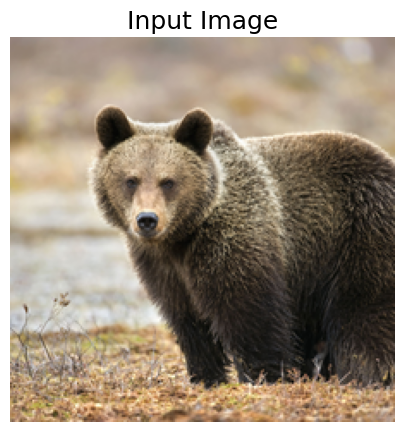

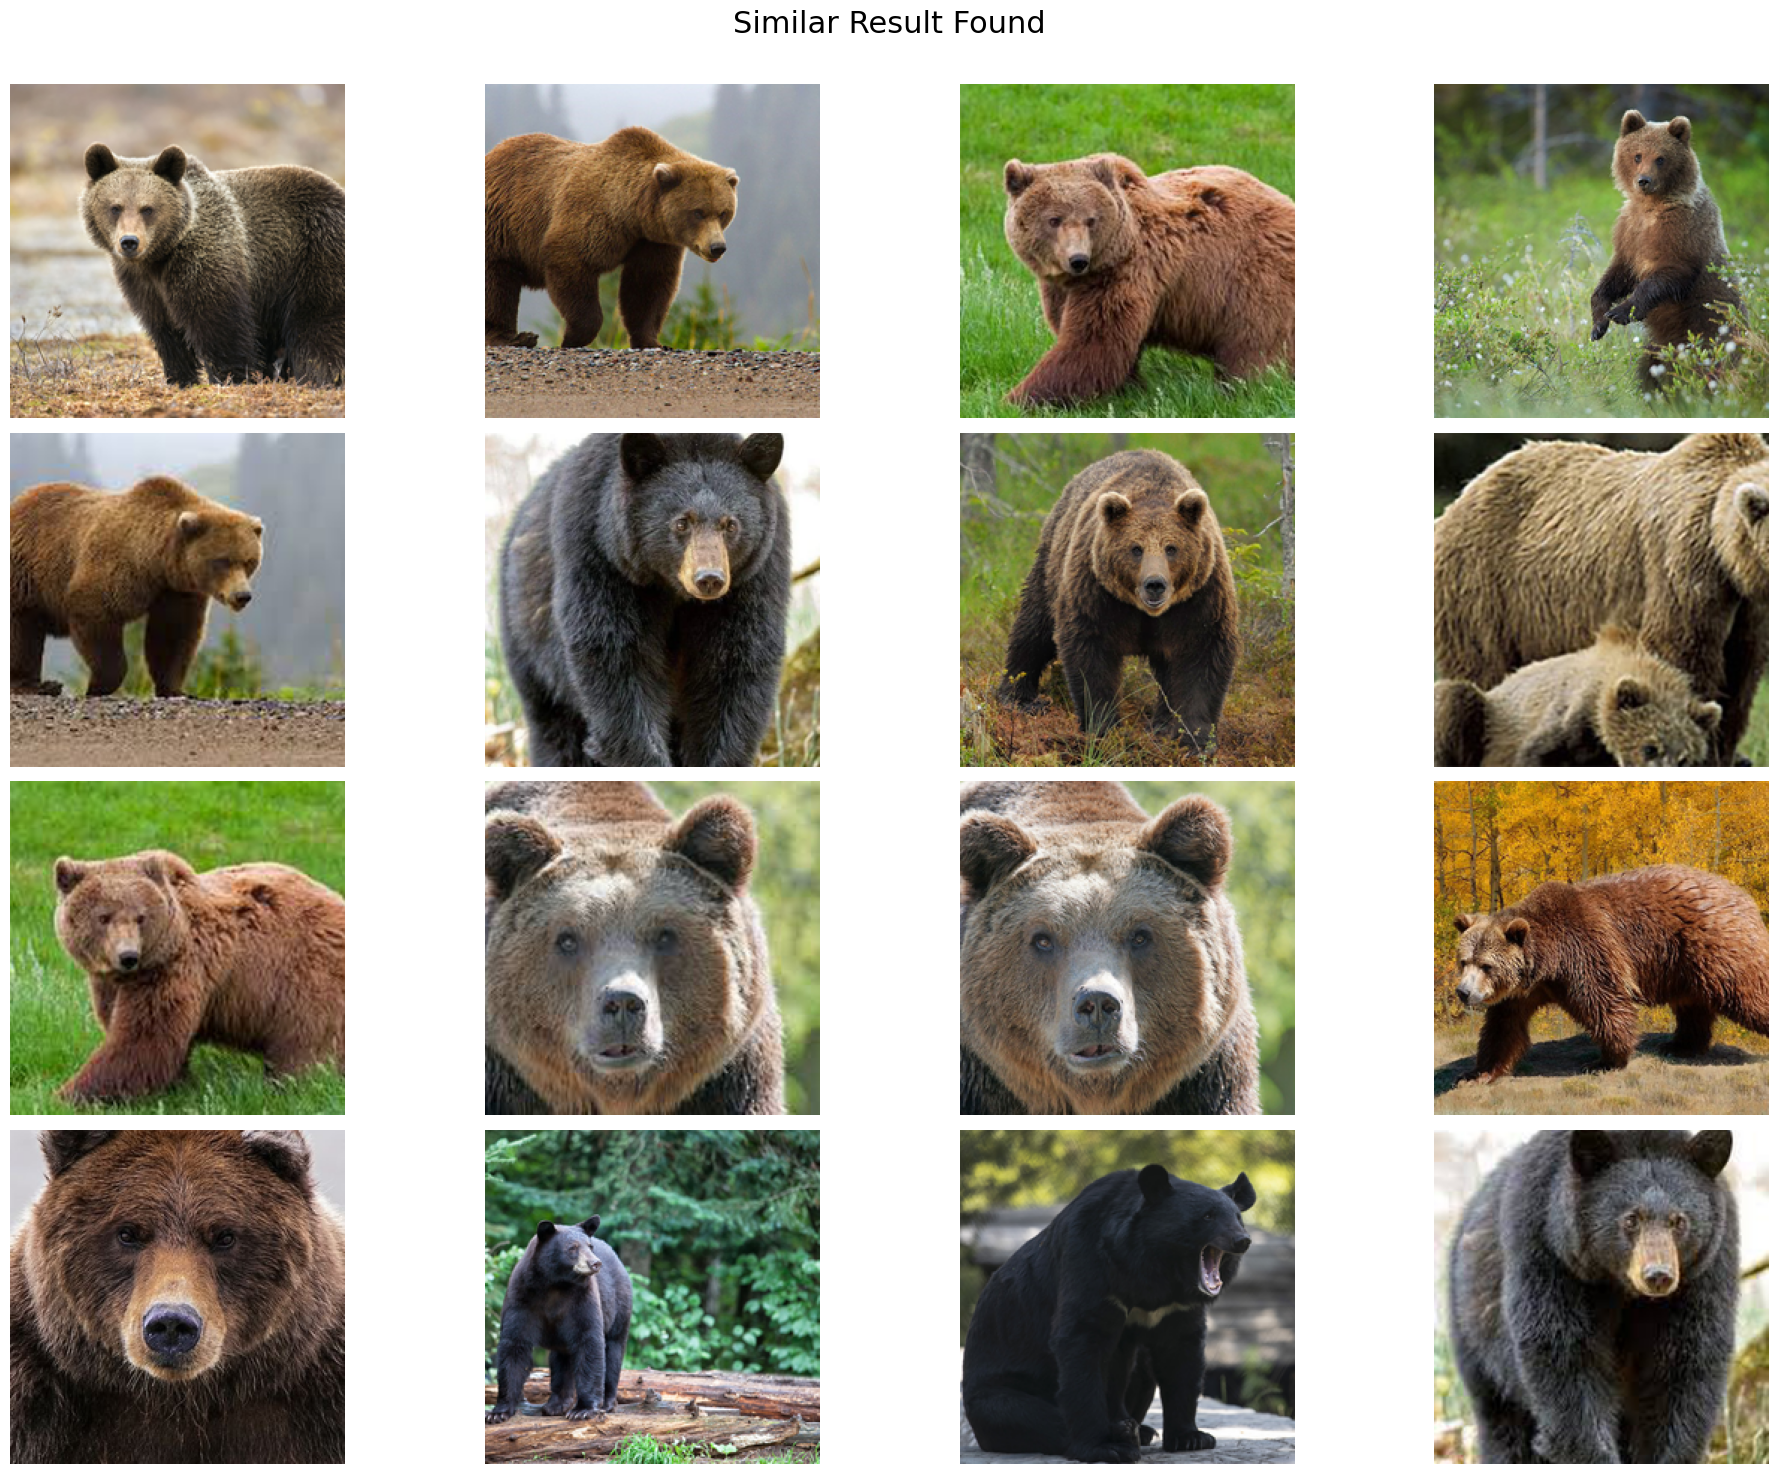

In [ ]:
# Plot similar images
st.plot_similar_images(image_path = image_list[350],number_of_images=16)